In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import matplotlib.font_manager as font_manager

In [3]:
import spacy
import string
nlp = spacy.load("en_core_web_lg")
stop_words = nlp.Defaults.stop_words
print(stop_words)

{'either', 'herself', 'most', 'make', 'everyone', 'was', 'part', 'same', 'might', 'next', 'itself', 'as', 'afterwards', 'anyhow', 'somehow', 'against', 'anything', 'those', 'your', 'anyway', 'quite', 'move', 'done', 'us', 'none', 'so', 'what', 'whenever', 'would', 'seeming', 'therefore', 'bottom', 'ten', 'often', 'otherwise', 'themselves', 'you', 'for', "'m", 'at', 'well', 'something', 'into', 'in', 'whole', 'ca', 'wherever', 'her', 'have', "'ve", 'two', 'rather', 'nothing', 'all', 'hereby', 'whom', 'upon', '’d', 'noone', 'nine', 'also', 'keep', 'per', 'first', 'go', 'sometime', 'last', 'thence', 'name', 'eleven', 'someone', 'various', 'get', 'within', 'almost', 'our', 'who', 'off', 'between', 'during', 'no', 'front', 'whoever', '‘s', 'among', 'wherein', 'of', 'seemed', 'whereupon', 'call', 'without', 'everything', 'fifteen', 'there', 'until', 'though', 'an', 'did', 'himself', 'hence', 'does', 'could', 'latter', 'only', 'put', 'made', 'toward', 'their', 'take', "n't", 'alone', 'now', '

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

In [9]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, ' ', raw_html)
    
    return cleantext
    
def cleantext(raw_text):
    cleantext = re.sub(r'[^\w]', ' ', raw_text)
    cleantext = re.sub(' +', ' ', cleantext)
    return cleantext

In [10]:
book_interaction = pd.read_csv("book_interaction_filter.csv")
book_description = pd.read_pickle("book_scapped_final.pkl")

In [14]:
import re

In [15]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, ' ', raw_html)
    
    return cleantext

def cleantext(raw_text):
    cleantext = re.sub(r'[^\w]', ' ', raw_text)
    cleantext = re.sub(' +', ' ', cleantext)
    return cleantext

In [16]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
book_description['new_description'] = book_description['description'].apply(cleanhtml).apply(cleantext)

In [14]:
sentences = book_description['new_description'].tolist()

In [ ]:
embeddings = model.encode(sentences, show_progress_bar=True)

In [39]:
np.save("embeddings_lm.npy", embeddings)

In [ ]:
book_description['embedding'] = embeddings.tolist()

In [ ]:
book_description["genre_top"] = book_description["genres"].str[0]

In [73]:
book_description.to_pickle("book_description_with_embedding.pkl")

In [4]:
book_description = pd.read_pickle("book_description_with_embedding.pkl")

In [6]:
book_description.shape

(416797, 17)

In [8]:
from sklearn.manifold import TSNE, MDS
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.font_manager as font_manager

In [9]:
# function to compute hopkins's statistic for the dataframe X
from numpy.random import uniform
from random import sample
from sklearn.neighbors import NearestNeighbors
def hopkins_statistic(X):
    
    # X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H

In [11]:
book_interaction = pd.read_csv("book_interaction_filter.csv")

In [12]:
final_user_list = np.loadtxt('final_user_list.txt', dtype=str) 

In [13]:
book_interaction_filter = book_interaction[book_interaction.reviewerID.isin(final_user_list)]

In [14]:
book_description.columns

Index(['description', 'title', 'genres', 'author', 'avg_rating',
       'rating_count', 'review_count', 'rating_1_count', 'rating_2_count',
       'rating_3_count', 'rating_4_count', 'rating_5_count', 'isbn', 'asin',
       'new_description', 'embedding', 'genre_top'],
      dtype='object')

In [15]:
book_description = book_description[book_description.isbn.isin(book_interaction_filter.asin.unique())]

In [16]:
all_book_embedding = np.array(book_description.embedding.dropna().tolist())

In [17]:
all_book_embedding.shape

(376333, 384)

In [21]:
y = book_description.avg_rating.tolist()

In [67]:
# Calculate hopkins statistics
hopkins_statistic(all_book_embedding)

0.7546714430947274

In [53]:
selected_genres = ['Science Fiction', 'Historical Fiction', 'Fantasy', 'Paranormal', 
                   'Mystery', 'Romance', 'Biography', 'Horror', 'Christian Fiction', 'Thriller']

In [54]:
book_samples = book_description[book_description.genre_top.isin(selected_genres)].groupby("genre_top").sample(1000, random_state=123, replace=False)

In [ ]:
sample_sequence = book_interaction_filter[book_interaction_filter.reviewerID == book_interaction_filter.reviewerID.unique()[658]]
sample_sequence = sample_sequence.merge(book_description, how="left", left_on="asin", right_on="isbn").dropna()
print(sample_sequence.overall.value_counts())
sample_sequence_embedding = np.asarray(sample_sequence.embedding.dropna().tolist())

embedding_sample = np.array(book_samples.embedding.tolist())

In [73]:
embedding_sample = np.concatenate([embedding_sample, sample_sequence_embedding])

In [74]:
tsne = TSNE(n_components=2, verbose=1)
z = tsne.fit_transform(embedding_sample)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10052 samples in 0.002s...
[t-SNE] Computed neighbors for 10052 samples in 0.339s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10052
[t-SNE] Computed conditional probabilities for sample 2000 / 10052
[t-SNE] Computed conditional probabilities for sample 3000 / 10052
[t-SNE] Computed conditional probabilities for sample 4000 / 10052
[t-SNE] Computed conditional probabilities for sample 5000 / 10052
[t-SNE] Computed conditional probabilities for sample 6000 / 10052
[t-SNE] Computed conditional probabilities for sample 7000 / 10052
[t-SNE] Computed conditional probabilities for sample 8000 / 10052
[t-SNE] Computed conditional probabilities for sample 9000 / 10052
[t-SNE] Computed conditional probabilities for sample 10000 / 10052
[t-SNE] Computed conditional probabilities for sample 10052 / 10052
[t-SNE] Mean sigma: 0.226927
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.680473
[t-SNE] KL d

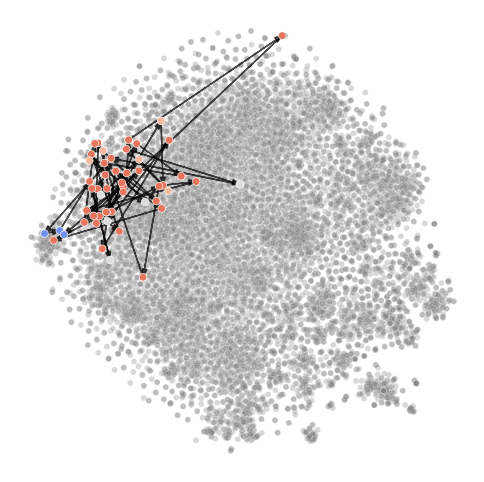

In [75]:
df = pd.DataFrame()

df["comp-1"] = z[:10000,0]
df["comp-2"] = z[:10000,1]

df["Genre"] = book_samples["genre_top"].tolist()

temp_trace = pd.DataFrame()

temp_trace["comp-1"] = z[10000:,0]
temp_trace["comp-2"] = z[10000:,1]

temp_trace["Genre"] = sample_sequence.genre_top.tolist()
temp_trace["rating"] = (sample_sequence.overall).tolist()

fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x="comp-1", y="comp-2", color="grey",
                size=4,alpha=0.3, 
                data=df)

for i in range(temp_trace.shape[0]-1):
    x = temp_trace["comp-1"][i]
    y = temp_trace["comp-2"][i]
    dx = temp_trace["comp-1"][i+1] - temp_trace["comp-1"][i]
    dy = temp_trace["comp-2"][i+1] - temp_trace["comp-2"][i]
    plt.arrow(x, y, dx, dy,
              head_width=2,
              length_includes_head=True, alpha=0.7,
              fc="black")
    
cmap= {1: sns.color_palette("coolwarm", 5)[0], 
     2: sns.color_palette("coolwarm", 5)[1], 
     3: sns.color_palette("coolwarm", 5)[2], 
     4: sns.color_palette("coolwarm", 5)[3], 
     5: sns.color_palette("coolwarm", 5)[4]}

sns.scatterplot(x="comp-1", y="comp-2", 
                s=30,alpha=1, hue="rating", palette=cmap,
                data=temp_trace)

    
font = font_manager.FontProperties(family='Arial',
                                   style='normal', size=10)
plt.legend('',frameon=False)


plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

/tmp/ipykernel_2259528/4268797764.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0]._sizes = [38]


[]

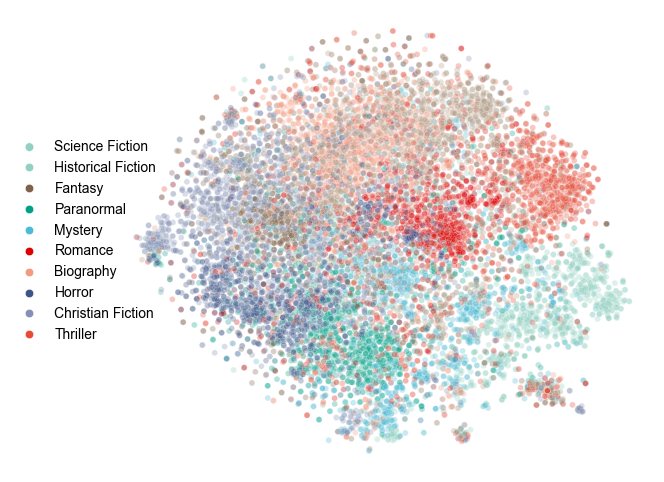

In [76]:
df = pd.DataFrame()

df["comp-1"] = z[:10000,0]
df["comp-2"] = z[:10000,1]

df["Genre"] = book_samples["genre_top"].tolist()

colors = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]

cmap = {selected_genres[i]:colors[i] for i in range(10)}

fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.scatterplot(x="comp-1", y="comp-2", hue="Genre",
                size=4,alpha=0.3, palette=cmap,
                data=df[df.Genre.isin(selected_genres)].dropna())

font = font_manager.FontProperties(family='Arial',
                                   style='normal', size=10)

labels=selected_genres

plt.legend(title='', loc='center left', bbox_to_anchor=(-0.2, 0.5),
           frameon=False, scatterpoints=1, labels=labels, framealpha = 1,
          prop=font)



leg = ax.get_legend()
leg.legendHandles[0]._sizes = [38]
plt.setp(leg.get_title(), family='Arial', size=16)
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.title("", fontdict={'fontfamily': 'Arial', 'fontsize': 18})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.plot()
